## QVMC Intro
Using the Illinois tutorial - https://clark.physics.illinois.edu/Tutorials/VMCIntroTutorial/index.html
Hydrogen molecule - one spin up, one spin down.

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from stats import Stats

In [2]:
def modulo(x):
    return sum([i**2 for i in x])

def euclidean_distance(r1, r2):

    dist = 0
    for i in range(len(r1)):
        dist += (r1[i] - r2[i]) ** 2
    
    return np.sqrt(dist) 

### Trial Wavefunction 1 - Gaussian with a variational width

In [190]:
def psi(coords, ions=None, alpha=0.5):
    return np.exp(- alpha * (modulo(coords[0]) + modulo(coords[1])))


In [189]:
psi_(np.array([[1.0 ,0.5 ,0.3], [-0.2, 0.1, -0.1]]))

np.float64(0.49658530379140947)

In [4]:
coords = [[1.0 ,0.5 ,0.3], [-0.2, 0.1, -0.1]]
psi(coords)

0.49658530379140947

### Accepting and rejecting moves

In [192]:
def VMC(WF, ions, numSteps):

    ratios = []
    coords_arr = []

    R = np.zeros((2, 2), float)
    movesAttempted = 0.0
    movesAccepted = 0.0
    coords = np.zeros((2, 3))
    original_WF = WF(coords, ions)
    for step in range(numSteps):
        for ptcl in range(len(R)):
            a = 5  # Define movement parameters
            # Implement move for particle 'ptcl'
            delta = 1
            move_coords = delta * 1.5 * np.random.rand(3)
            move_coords[2] = 0
            new_coords = coords.copy()

            if random.random() <= 0.5:
                new_coords[ptcl] += move_coords
            else:
                new_coords[ptcl] -= move_coords
            
            new_WF = WF(new_coords, ions)

            if new_WF:
                
                ratio = (new_WF / original_WF) ** 2

                if random.random() <= ratio:
                    movesAccepted += 1
                    coords_arr.append(new_coords[ptcl])
                    #coords = new_coords.copy()
                    #original_WF = new_WF
                
                ratio = min(1, ratio)
                ratios.append(ratio)

            movesAttempted += 1
            
    print("Acceptance ratio:", movesAccepted / movesAttempted)
    return coords_arr

In [193]:
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])
coords_arr = VMC(psi, ions=ions, numSteps=10000)

Acceptance ratio: 0.32365


In [194]:
coords_x = [i[0] for i in coords_arr]

Text(0.5, 1.0, 'Electron density along x')

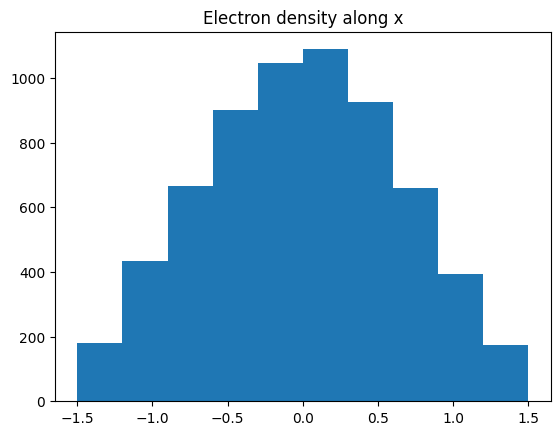

In [195]:
plt.hist(coords_x)
plt.title("Electron density along x")

### Local energy

In [196]:
def LaplacianPsiOverPsi(wavefunction, R, alpha, ions=None, delta=1e-3):
    r_plus = np.copy(R)
    r_minus = np.copy(R)
    wavefunction_current = wavefunction(R)

    kinetic_energy = 0.0
    for i in range(2):
        for j in range(3):
            r_plus[i, j] += delta
            r_minus[i, j] -= delta

            wave_function_plus = wavefunction(r_plus)
            wave_function_minus = wavefunction(r_minus)

            kinetic_energy -= (
                wave_function_minus + wave_function_plus - 2 * wavefunction_current)

            r_plus[i, j] = R[i, j]
            r_minus[i, j] = R[i, j]

    # Kinetic energy
    kinetic_energy = kinetic_energy *  0.5 * 1e6 / wavefunction_current

    return kinetic_energy

def LocalEnergy(wavefunction, coords, ions, alpha, display=False):

    kinetic_energy = LaplacianPsiOverPsi(wavefunction, coords, alpha)
    
    ion_electron_potential = 0

    for i in coords:
        for j in ions:
            ion_electron_potential -= 1 / euclidean_distance(i, j)

    electron_electron_potential = 1 / (euclidean_distance(coords[1], coords[0]))

    ion_ion_potential = 1 / (euclidean_distance(ions[0], ions[1]))

    if display:
        print(f"Electron potential {electron_electron_potential}\n"
            f"Ion potential {ion_ion_potential}\n"
            f"Ion electron potential {ion_electron_potential}\n"
            f"Kinetic energy {kinetic_energy}"
            )
    potential_energy = electron_electron_potential + ion_ion_potential + ion_electron_potential

    return potential_energy + kinetic_energy

In [197]:

R = np.zeros((2,3), float)
R[0] = [1.0, 0.3, 0.2]
R[1] = [2.0, -0.2, 0.1]

# Set your ions so that the bond length is 1.4
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])

print(LocalEnergy(psi, np.array([R[0], R[1]]), ions, alpha=0.5, display=True))

Electron potential 0.8908708063747479
Ion potential 0.7142857142857143
Ion electron potential -3.834647280046225
Kinetic energy 0.4099998375432463
-1.8194909218425162


In [ ]:

# Local energy addition

def VMC_energy(WF, ions, numSteps, alpha):
    
    movesAttempted = 0.0
    movesAccepted = 0.0
    coords = np.zeros((2, 3))
    E = 0
    E2 = 0

    coords = np.random.rand(2,3) - 0.5

    original_WF = WF(coords, alpha)

    for step in range(numSteps):
        for ptcl in range(2):

            delta = 1.5
            move_coords =  1.5 * (np.random.rand(3) - 0.5)
            new_coords = coords.copy()

            if random.random() > 0.5:
                new_coords[ptcl] += move_coords
            else:
                new_coords[ptcl] -= move_coords
            
            new_WF = WF(new_coords, alpha)

            ratio = (new_WF ** 2) / (original_WF ** 2)

            if random.random() <= ratio:
                movesAccepted += 1
                coords = new_coords.copy()
                original_WF = new_WF
                
            dE = LocalEnergy(
                WF, coords, ions, alpha)
            E += dE
            E2 += dE ** 2
            movesAttempted += 1


    n_samples = numSteps * 2

    print("Acceptance ratio:", movesAccepted/movesAttempted)
    return E / n_samples, (E**2 - E2) / n_samples

In [240]:
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])
energies = VMC_energy(psi, ions=ions, numSteps=10000, alpha=0.3)

Acceptance ratio: 0.62045


In [241]:
energies

(np.float64(-0.8511112457439738), np.float64(14485.592406840235))

In [242]:
# Marching alpha

energies_arr= []
variances_arr = []
alpha_arr = np.arange(0.1, 0.6, 0.05)

for alpha in tqdm(alpha_arr):
    energy, variance = VMC_energy(psi, ions=ions, numSteps=10000, alpha=alpha)
    energies_arr.append(energy)
    variances_arr.append(variance)

  0%|          | 0/10 [00:00<?, ?it/s]

Acceptance ratio: 0.6183
Acceptance ratio: 0.61225
Acceptance ratio: 0.6155
Acceptance ratio: 0.61195
Acceptance ratio: 0.60605
Acceptance ratio: 0.61505
Acceptance ratio: 0.61325
Acceptance ratio: 0.60885
Acceptance ratio: 0.61905
Acceptance ratio: 0.61245


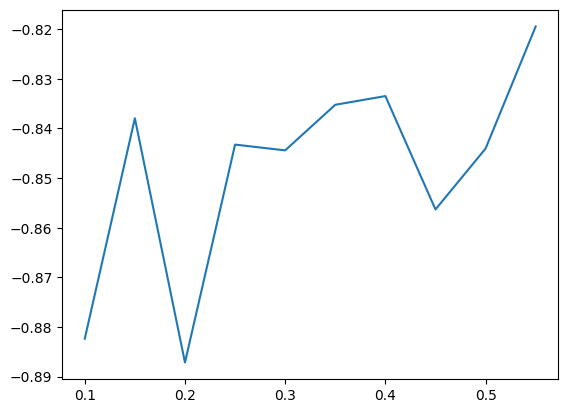

In [243]:
plt.plot(alpha_arr, energies_arr)

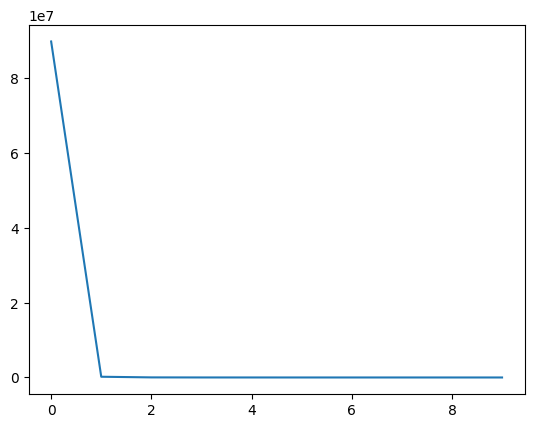

In [88]:
plt.plot(variances)